In [6]:
import urllib2, json, nltk
import math, random, time, pdb, pickle

LOAD = False
global debug; debug=True

In [ ]:
class nyTimesReader:
    """Creates a dictionary of search result data from a previously pickled file or from an HTTP GET request
        NYTimes Article API v2"""
    def __init__(self, *args, **kwargs): #should replace with None's probably
        #Parse input
        self.filename = kwargs.get('filename','nyTimesDataObject')
        self.startdate = kwargs.get('startdate','20150814')
        self.enddate = kwargs.get('enddate','20150814')
        self.query = kwargs.get('query','____').replace(' ','+')
        self.pagelim = kwargs.get('pagelim',2)
        #Defaults
        self.url_base = 'http://api.nytimes.com/svc/search/v2/articlesearch.json?'
        self.url_key = '&api-key=6940176db80043d5a17343d873cfc82e'
        self.response = None
        global debug
        
    def loadFile(self):
        outfile = open(self.filename,'r')
        self.response = pickle.load(outfile)
        
    def saveFile(self):
        outfile = open(self.filename,'w')
        pickle.dump(self.response,outfile)
        
    def getResponse(self):
        """Requests data from the NYTimes API and saves the result"""
        self.response = []
        # we use different methods if getting with or without a keyword 
        if self.query is '____':
            for d in range(int(self.startdate), int(self.enddate)+1):
                date=str(d)
                self.__getDate(date,date)
        else:
            self.__getDate(self.startdate,self.enddate)
        self.saveFile()  
        
    def getNounsLeadP(self):
        """Returns a list of proper nouns from the lead paragraph of all articles"""
        if self.response is None:
            print 'no data in object, get or load data first'
            self.noun_list_lead_P = None
        else:
            self.noun_list_lead_P = []
            for page in range(0,len(self.response)):
                for i in range(0,9):
                    paragraph = self.response[page]['response']['docs'][i]['lead_paragraph']
                    if not(paragraph == ''or paragraph is None):
                        text = nltk.word_tokenize(paragraph)
                        poses = nltk.pos_tag(text)
                        prev_noun_flag = False;
                        for item in poses:
                            if item[1] == 'NNP':
                                if prev_noun_flag:
                                    self.noun_list_lead_P[-1]=self.noun_list_lead_P[-1] + ' ' + item[0]
                                else:
                                    self.noun_list_lead_P.append(item[0])
                                prev_noun_flag = True
                            else: prev_noun_flag = False
            if debug: print '\n'+str(len(self.noun_list_lead_P))+' nouns found'
        return self.noun_list_lead_P
            
    def getHeadlines(self):
        if self.response is None:
            if debug: print 'no data in object, get or load data first'
            self.noun_list_lead_P = None
        else:
            self.headline_list = []
            for page in range(0,len(self.response)):
                for i in range(0,9):
                    self.headline_list.append(self.response[page]['response']['docs'][i]['headline']['main'])
            if debug: print '\n'+str(len(self.headline_list))+' headlines'
        return self.headline_list

    def getLeadParagraphs(self):
        paragraphs = []
        for page in range(0,len(self.response)):
            for i in range(0,9):
                paragraphs.append(self.response[page]['response']['docs'][i]['lead_paragraph'])
        if debug: print '\n'+str(len(paragraphs))+' paragraphs'
        return paragraphs
    
    def searchLeadParagraph(self,term):
        """searches lead paragraphs for terms, case-sensitive"""
        paragraphs = self.getLeadParagraphs()
        returned = []
        for paragraph in paragraphs: 
            if term in paragraph: returned.append(paragraph)
        if debug: print '\n'+str(len(returned))+' matching paragraphs found'
        return returned
    
    def searchHeadlines(self,term):
        """searches the headlines for a term, regardless of case"""
        headlines = self.getHeadlines()
        returned = []
        for headline in headlines: 
            if term.lower() in headline.lower(): returned.append(headline)
        if debug: print '\n'+str(len(returned))+' matching headlines found'
        return returned
            
    def __getDate(self,startdate,enddate):
        data = self.__getPage(0,startdate,enddate)
        self.num_pages = int(math.floor(data['response']['meta']['hits']/10))-1
        if debug: print 'for '+ startdate + ' to ' + enddate +', ' + \
            str(self.num_pages)+' pages found, returning '+str(min(self.num_pages,self.pagelim))+'\n    ',
        for page in range(0,min(self.num_pages,self.pagelim)):
            self.response.append(self.__getPage(page,startdate,enddate))
            if debug: print str(page), 
        if debug: print ''
        
    def __getPage(self,page,startdate,enddate):
        url_page = '&page=' + str(page)
        url_date = '&begin_date='+startdate+'&end_date='+enddate
        url_query = '' if self.query is '____' else 'q='+self.query
        if page>100: raise NameError('Cannot request beyond page 100')
        self.url_assembled = self.url_base + url_query + url_date + url_page + self.url_key
        response = urllib2.urlopen(self.url_assembled)
        json_data = response.read()
        data = json.loads(json_data)
        return data

In [8]:
# CONSTRUCT THE TWO LISTS

if not(LOAD):
    print 'TEST RANGE'
    startdate = '19850807'
    enddate = '19850821'

    nyt=nyTimesReader(startdate=startdate, enddate=enddate,
        filename='data/nyTimesData'+'_'+startdate+'_'+enddate, pagelim=50)
    nyt.getResponse()
    noun_list_test = nyt.getNounsLeadP()

    print '\n CONTROL RANGE'
    startdate = '20150807'
    enddate = '20150821'

    nyt_control=nyTimesReader(startdate=startdate, enddate=enddate,
        filename='data/nyTimesData'+'_'+startdate+'_'+enddate, pagelim=50)
    nyt_control.getResponse()
    noun_list_control = nyt_control.getNounsLeadP()

TEST RANGE


HTTPError: HTTP Error 403: Forbidden

In [154]:
nyt.url_assembled

'http://api.nytimes.com/svc/search/v2/articlesearch.json?&begin_date=19850821&end_date=19850821&page=28&api-key=70d20c6634e9bb4a4db7b7c9bc0f099d:17:59783841'

In [4]:
# OR LOAD THE TWO LISTS
if LOAD:
    nyt=nyTimesReader(filename='data/nyTimesData_19850807_19850821')
    nyt.loadFile()
    noun_list_test = nyt.getNounsLeadP()
    headlines = nyt.getHeadlines()

    nyt_control=nyTimesReader(filename='data/nyTimesData_20150807_20150821')
    nyt_control.loadFile()
    noun_list_control = nyt_control.getNounsLeadP()


23250 nouns found

3897 headlines

25477 nouns found


In [11]:
# Get only the nouns that are in test but not control
noun_list_novel = list(set(noun_list_test) - set(noun_list_control))

if debug: print str(len(noun_list_novel)) + ' nouns unique to the test set, such as:'
for count in range(1,5):
    if debug: print noun_list_novel[random.randrange(0, len(noun_list_novel), 1)]
                       
if debug: print str(len(headlines)) + ' headlines in the test set, such as:'
for count in range(1,5):
    if debug: print headlines[random.randrange(0, len(headlines), 1)]

8215 nouns unique to the test set, such as:
CARLOS CORREA
National Coalition Against Domestic Violence
Air Jamaica
Drexel
3897 headlines in the test set, such as:
U.S., Japan Set Chip Talks
ATV SYSTEMS INC reports earnings for Qtr to June 30
ONE AMATEUR STAYS, ONE MOVES ON
LITTLEFIELD, ADAMS & CO reports earnings for Qtr to June 30


In [157]:
noun_list_union = list(noun_list_test) + list(noun_list_control)
noun_list_union = [i.encode('ascii','ignore') for i in noun_list_union]
len(noun_list_union)

48727

In [7]:
#count w counter
import collections
counter_nouns =  collections.Counter(noun_list_novel) 
freq_words_counter = counter_nouns.most_common(100)
if debug: print [i[0] for i in freq_words_counter]

[u'Sedat Sirri Kadem', u'Szczecin', u'Sugar', u'Cooperstown', u'Does', u'Assemblyman Herman D. Farrell Jr.', u'Schuster', u'Vermont Exchange', u'Hoyas', u'Rabbi Leigh D. Lerner', u'Baader-Meinhof Gang', u'Defense Minister Yitzhak Rabin', u'Trinidad-born', u'Monmouth County', u'William R. Dabney', u'Slawomir Bielecki', u'Mr. Lynch', u'Turner Broadcasting', u'Redding', u'Joe Wood', u'Aguilera', u'Mrs. von Bulow', u'Less', u'Retirement Equity Act', u'Tuxedo', u'Mr. Stockman', u'Shanghai Corning Engineering Corporation', u"''are", u'DURBAN', u'Mr. Cariello', u'Gen. John M. Schofield', u'Holsteins', u'BankAmerica International', u'Sharon Jane Schreiber', u'Mayor Thomas Dunn', u'Barclays Bank P.L.C', u'Individual Investor', u'FOLK FESTIVAL Bonnie Raitt', u'Perrin Long', u'Wrong', u'Alps Group', u'Malibu Grand Prix', u"JOHN O'CONNOR Research Triangle Park", u'Presidential', u'Dr. Backman', u'Seuffert Band', u'Sioux', u'Major League Productions', u'Budget', u'Stuttgart', u'BASF Wyandotte Corpo

In [8]:
#Manual method, but TOOO SLOOOOW
# noun_list_man=noun_list_union[:1000];
# freq_words = []
# for word,freq in list_sorted_count.iteritems():
#     if freq>1:
#         freq_words.append((word,freq))
# freq_words.sort(key = lambda x: x[1])
# freq_words.reverse()
# freq_words[:10]

In [12]:
# convert list into string, combining multi-word phrases into single words
noun_list_no_spaces = list(noun_list_novel)
noun_list_no_spaces[:]=[item.encode('ascii').replace(' ','') for item in noun_list_no_spaces] 
string_of_nouns = ' '.join(noun_list_no_spaces)

headlines_no_spaces = list(headlines)
headlines_no_spaces[:]=[item.encode('ascii').replace(' ','') for item in headlines_no_spaces] 
string_of_headlines = ' '.join(headlines_no_spaces)


In [22]:
# Plot that shit
# The pil way (if you don't have matplotlib)
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
from os import path


leo_mask = np.array(Image.open("leo_paint_color.png"))

wc_noun = WordCloud(background_color="white", max_words=5000, mask=leo_mask, max_font_size=48)
wc_noun.generate(string_of_nouns)
#wc_head = WordCloud(background_color="white", max_words=5000, mask=leo_mask, max_font_size=24)
#wc_head.generate(string_of_headlines)


#recolor
image_colors = ImageColorGenerator(leo_mask)
wc_noun.recolor(color_func=image_colors)
#wc_head.recolor(color_func=image_colors)

#save
wc_noun.to_file("leo_out_nouns.png")
#wc_head.to_file("leo_out_head.png")

#show
image_noun = wc_noun.to_image()
image_noun.show()
#image_head = wc_head.to_image()
#image_head.show()




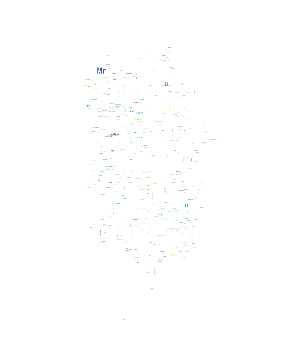

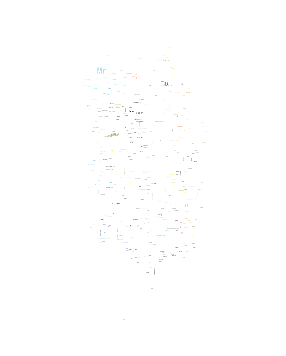

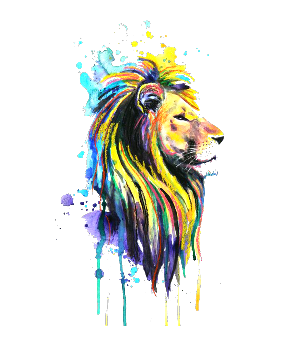

In [21]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#d = path.dirname(__file__)

# Read the whole text.
text = string_of_nouns #open(path.join(d, 'alice.txt')).read()

# read the mask / color image taken from
# http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
alice_coloring = np.array(Image.open("leo_paint_color copy.png"))
#stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_coloring,
                max_font_size=40, random_state=42) #stopwords=stopwords
# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(alice_coloring)

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.figure()
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.imshow(alice_coloring, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
startdate = '19850807'
enddate = '19850821'

nytt=nyTimesReader(query='William J', startdate=startdate, enddate=enddate,
    filename='data/nyTimesData'+'_'+startdate+'_'+enddate+'lite', pagelim=50)
nytt.getResponse()

HTTPError: HTTP Error 403: Forbidden

In [11]:
paragraphs = nytt.searchLeadParagraph('Bennet')

NameError: name 'nytt' is not defined

In [164]:
nytt.searchHeadlines('bennet')


72 headlines

1 matching headlines found


[u'BENNETT VOWS AID TO CHURCH SCHOOLS']

In [165]:
from wordcloud import WordCloud, ImageColorGenerator
import wordcloud
#help(wordcloud)

In [166]:
#help(nyTimesReader)

In [167]:
import inspect 
inspect.getfile(wordcloud)


'//anaconda/lib/python2.7/site-packages/wordcloud/__init__.pyc'